<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

try:
    import google.colab  # noqa: F401
except ImportError:
    import pyvista as pv
else:
    !wget "https://fem-on-colab.github.io/releases/vtk-install.sh" -O "/tmp/vtk-install.sh" && bash "/tmp/vtk-install.sh"
    import pyvista as pv

# Seems that only static plotting is supported by colab at the moment
pv.global_theme.jupyter_backend = "static"
pv.global_theme.notebook = True
pv.start_xvfb()
#pv.set_jupyter_backend('trame')

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,623 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 1,852 kB in 2s (1,229 kB/s)
Reading package lists... Done
--2024-01-22 11:55:36--  https://fem-on-colab.github.io/releases/vtk-install.sh
Resolving fem-on

Given a numerical approximation of a random field or random function $Y(\boldsymbol{x})$ over an arbitrary domain $\boldsymbol{x} \in \Omega$ (which can be thought of as a multidimensional space $\mathbb{R}^n$), we want to calculate its corresponding cumulative density function (CDF) $F(y)$ and probability density function (PDF) $f(y)$ such that these functions are continuous and make the best possible use of the available data. The CDF of $Y(\boldsymbol{x})$ is given by
\begin{equation*}
    F(y) = \int_{\Omega} \mathbb{I}(y,\boldsymbol{x}) d \boldsymbol{x},
\end{equation*}
where the indicator function is given by
\begin{equation*}
    \mathbb{I}(y,\boldsymbol{x}) =
    \begin{cases}
    1 \quad &: Y(\boldsymbol{x}) < y, \\
    0 \quad &: \text{otherwise}.
    \end{cases}
\end{equation*}
Differentiating the CDF its PDF $f(y) = \partial_y F(y)$ is then easily recovered. While seemingly simple the integral of the indicator function is in practice difficult to calculate numerically and the common approach is to jump directly from the analytical expression for $F(y)$ directly to its piecewise constant approximation outlined below.

To illustrate this consider calculating the CDF of $Y(\boldsymbol{x}_i) = (Y_1, Y_2, \cdots ,Y_n)$ here taken to be a uniformly sampled vector of $n$ discrete points. To calculate a discrete approximation of its CDF we can sort the data to obtain
\begin{equation*}
    F(y) \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y}
\end{equation*}
which jumps up by $1/n$ at each data point and thus lets the data discretise the codomain $\Omega_{Y}$, or we can impose a discretisation of $m$ bins $y_0 < y_1 < \cdots < y_m$ and obtain the approximation
\begin{equation*}
    F(y_m) \approx \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{Y_i \leq y_m}
\end{equation*}
which jumps up between bins by $F(y_2) - F(y_1) \neq 1/m$, and takes a constant value within each bin. While this gaurantees a monotonic CDF it is clearly discontinuous and has not made the best use of our data as shown in the example below.

Here we consider the function $Y(x_1) = \sin(x_1)^2$ where $x_1 \in [0,2 \pi)$, and plot its CDF $F_Y(y)$ a contour level of its CDF $F_Y(y)$ as function of $x_1,y$ as well as the indicator function $\mathbb{I}(y,x_1)$.

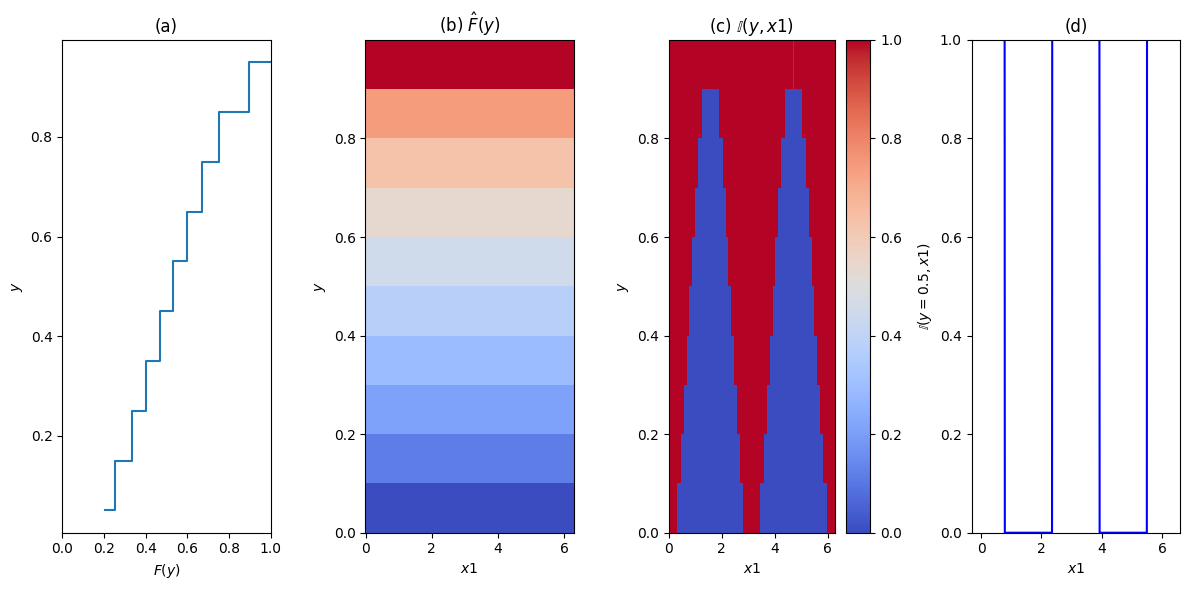

In [118]:
import numpy as np
import matplotlib.pyplot as plt

n    = 10    # Number of bins
n_x1 = 10**3 # Numerical grid for Y(x_1)

# Function
x1 = np.linspace(0,2*np.pi,n_x1)
Y  = lambda x: np.sin(x)**2;

# Indicator function
I  = lambda Y,y_m: [1 if Y_i < y_m else 0 for Y_i in Y];

# Construct CDF
dy  = abs( max(Y(x1)) - min(Y(x1)) )/n;
y   = np.arange(min(Y(x1)),max(Y(x1))+dy,dy);

IYX = np.zeros((n,n_x1))
for i,y_m in enumerate(y[1:]):
  IYX[i,:] = I(Y(x1),y_m) # If Y(x1) < y_n left bin edge

F  = np.mean(IYX,axis=1)  # Integrate out x
y_c= (y[1:] + y[:-1])/2.; # Convert to bin centres

fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(141)
ax1.plot(F,y_c,drawstyle='steps-mid')
ax1.set_xlim([0,1])
ax1.set_title(r'(a)')
ax1.set_ylabel(r'$y$')
ax1.set_xlabel(r'$F(y)$')

ax2 = fig.add_subplot(142)
ax2.set_title(r'(b) $\hat{F}(y)$')
ax2.pcolormesh(x1,y_c,np.outer(np.ones(n_x1),F).T,cmap='coolwarm')
ax2.set_xlabel(r'$x1$')
ax2.set_ylabel(r'$y$')

ax3 = fig.add_subplot(143)
ax3.set_title(r'(c) $\mathbb{I}(y,x1)$')
im = ax3.pcolormesh(x1,y_c,IYX,cmap='coolwarm')
fig.colorbar(im, ax=ax3)
ax3.set_xlabel(r'$x1$')
ax3.set_ylabel(r'$y$')

ax4 = fig.add_subplot(144)
ax4.plot(x1,I(Y(x1),0.5),'b')
ax4.set_ylim([0,1])
ax4.set_title(r'(d)')
ax4.set_xlabel(r'$x1$')
ax4.set_ylabel(r'$\mathbb{I}(y=0.5,x1)$')

# hist, bin_edges = np.histogram(Y(x1), bins='auto',density=True)
# yy = .5*(bin_edges[1:] + bin_edges[:-1])
# plt.plot(yy,hist)
# plt.show()

plt.tight_layout()
plt.show()

In the example above we have (1) implicitly assumed a basis of piecewise constant functions and (2) regarded the random field not as a continuous function of space but instead as a vector of grid point evaluations. How do we refine this "binning" approach?

To address the first point we can define an appropriate function space $V_F$ for $F$. While this could be the space of continuous functions, for simplicity we choose the space of square integrable functions
\begin{equation*}
    F \in V_F \subset L^2(\Omega_Y), \quad \text{where} \quad F: \Omega_Y \to [0,1] \quad \text{s.t.} \; \int F^2 dy < \infty,
\end{equation*}
and define the set of basis functions $V_F = span\{\phi_i(y)\}$ such that
\begin{equation*}
    F(y) = \sum_i f_i \phi_i(y).
\end{equation*}
While this does not garauntee continuity it does garauntee monotonicity and as we will see the former property is not strictly necessary if we only require $f(y)$ to be continuous. Thus by formulating the problem in this manner we can modify the definition of $V_F$ as required.


To address the second point we now consider the projection of $F(y)$ into $V_F$ as defined by
\begin{equation*}
    \int_{\Omega_Y \times \Omega} \hat{F} \hat{v} \; dy d \boldsymbol{x} = \int_{\Omega_Y \times \Omega} \mathbb{I}(y,\boldsymbol{x}) \hat{v} \; dy d \boldsymbol{x},
\end{equation*}
where $\hat{v},\hat{F} \in \hat{V}_F$ denotes the extension of $v,F \in V_F$ into $\Omega$. Substituting in for $\hat{F}$ and considering the projection component-wise we obtain
\begin{equation*}
    \sum_{i,j} \left[ \int_{\Omega_Y \times \Omega} \hat{\phi}_i \hat{\phi}_j \; dy d \boldsymbol{x} \right] f_j = \sum_i \left[ \int_{\Omega_Y \times \Omega} \mathbb{I}(y,\boldsymbol{x}) \hat{\phi}_i(y,\boldsymbol{x}) \; dy d \boldsymbol{x} \right],
\end{equation*}
where the left hand side denotes the bilinear form and the right hand side the linear form. As $\mathbb{I}(y,\boldsymbol{x})$ is analytic and $Y(\boldsymbol{x})$ is treated as a random function of space we have not made any approximation of the right hand side!


Applying this equation to the example problem, we find that the precise statement of these function spaces for $\hat{F}$ and its basis functions $\hat{v}$ is
\begin{equation}
    \hat{V}_F = V_F \times R,
\end{equation}
the space of square integrable functions $V_F$ times $R$ the space of functions which are constant over the whole domain. These spaces correspond to the $y$ and $x_1$ axis of frame (b) in the example shown above, whose 1D projection is shown in frame (a). In frames (c) and (d)  we highlight the discontinuous dependence of the indicator function on $y,x_1$. To realise these function spaces we will make use of the finite element code Firedrake.

We begin by constructing a mesh for $\boldsymbol{x} \in \Omega$ which if 1D is an interval mesh and if 2D a rectangular mesh. As we have an analytical expression or at least have a continuous representation of our data we can replace the real space $R$ by a single Discrete Galerkin element of zero order (DG0). Extruding this mesh into $y \in \Omega_Y$ and ascribing to it $Ny$ elements of type DG0 we specify a function for $F(y)$.

In [253]:
from firedrake import *

# Construct the mesh
Ny   = 25
#m_x  = IntervalMesh(1,0,2*np.pi); cell_type = "interval";  # x-direction
m_x  = RectangleMesh(1,1,Lx=2*np.pi,Ly=2*np.pi, originX=0.0, originY=0.0); cell_type = "triangle";
mesh = ExtrudedMesh(m_x, layers=Ny,layer_height=1./Ny,extrusion_type='uniform') # y-direction
File("Exruded_Mesh.pvd").write(mesh)

# Set the function-space \hat{V}_F
R   = FiniteElement(family="DG" ,cell=cell_type,degree=0)
V_F = FiniteElement(family="DG",cell="interval",degree=0)

elt_RVF = TensorProductElement(R,V_F)
V_hat_F = FunctionSpace(mesh,elt_RVF)

With the function spaces defined we then define the indicator function $\mathbb{I}(y,\boldsymbol{x})$ which acts on the random function $Y(\boldsymbol{x})$

In [259]:
# Define the indicator function
x1,x2,y = SpatialCoordinate(mesh)
Indicator = conditional( sin(x1)**2  < y, 1.0, 0.0)

To inspect and visualise the mesh created we can use pyvista

In [ ]:
# Get information on the mesh
reader = pv.get_reader(filename="Exruded_Mesh.pvd")
fdrake_mesh = reader.read()[0]
fdrake_mesh

# Visualise the mesh
static_plotter = pv.Plotter()
static_plotter.add_mesh(fdrake_mesh, color='black', style='wireframe', line_width=2)
static_plotter.add_points(fdrake_mesh.points, color='red', point_size=4)
static_plotter.add_axes()
#static_plotter.camera_position = 'xy'
static_plotter.show()

while to check the indicator function is behaving as expected we can plot it out on a piecewise constant function space $V_I$

Discontinuous Lagrange


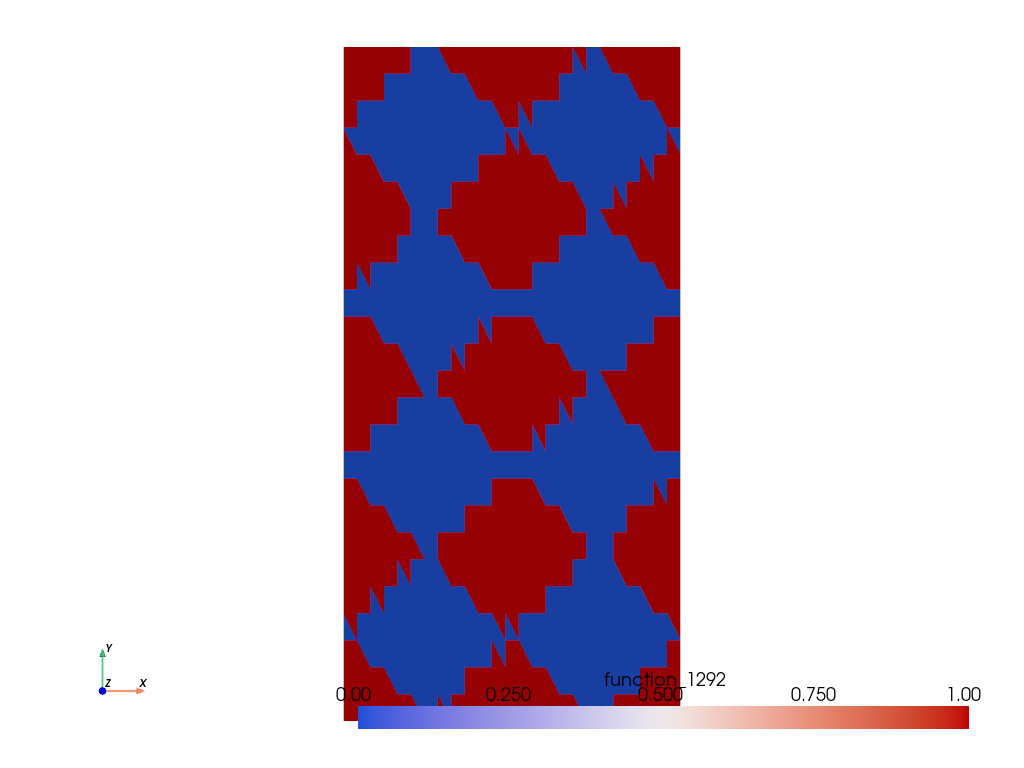

In [245]:
# Visualisation of the indicator function
N_vis = 25
#mI_x = IntervalMesh(N_vis,0,2*np.pi); cell_type = "interval";  # x-direction
mI_x  = RectangleMesh(N_vis,N_vis,Lx=2*np.pi,Ly=4*np.pi, originX=0.0, originY=0.0); cell_type = "triangle";
meshI = ExtrudedMesh(mI_x, layers=N_vis,layer_height=1./N_vis,extrusion_type='uniform') # y-direction

# Set the function-space V_I
W   = FiniteElement(family="DG",cell=cell_type ,degree=0)
V_F = FiniteElement(family="DG",cell="interval",degree=0)

elt_WVF = TensorProductElement(W,V_F)
V_I     = FunctionSpace(meshI,elt_WVF)

I = Function(V_I)
I.interpolate( Indicator )
File("Indicator_Function.pvd").write(I)

reader = pv.get_reader(filename="Indicator_Function.pvd")
fdrake_mesh = reader.read()[0]
fdrake_mesh.plot(cpos='xy',cmap='coolwarm')

We then declare the bilinear and linear forms for the left and right hand sides of our equation and then we solve the equation, by defining $F$ to be a function holding the solution and then passing this along with $a$ and $L$ to a solver. An additional argument we specify when constructing the linear form is the degree of the quadrature rule used to integrate the right hand side. A high order rule is necessary to contend with the discontinuous dependency of the indicator function.

In [260]:
u = TrialFunction(V_hat_F)
v = TestFunction(V_hat_F)

a = inner(u,v) * dx
L = inner(Indicator,v) * dx(degree=300) # Enforece a high order quadrature rule

F_hat = Function(V_hat_F)
solve(a == L,F_hat)
File("CDF_Extended.pvd").write(F_hat)

To recover the 1D function $F(y)$ we then create a new mesh and ascribe a function space upon which we can define a function to contain the data associated with the extended function's $\hat{F}(y,\boldsymbol{x})$ DOF.

In [261]:
# Define a mesh,function space & the CDF F which lives in this space
m_y = IntervalMesh(Ny,0,1);
V_F = FunctionSpace(mesh=m_y,family="DG",degree=0);
F   = Function(V_F)

# create new function y_Fs on function space V
y,  = SpatialCoordinate(m_y)
y_Fs= interpolate(y,V_F) # Creates a function y in V_F

# Now we sort these in ascending order
# This is because the DOFs for the extended mesh are in ascending order
indx = np.argsort(y_Fs.dat.data)

# Pass the data from F_hat into F
if len(F_hat.dat.data) == len(indx):
  F.dat.data[indx] = F_hat.dat.data[:]
else:
  # Take the average over the two triangles
  F.dat.data[indx] = 0.5*(F_hat.dat.data[:len(indx)] + F_hat.dat.data[len(indx):])

Finally we can plot this out using firedrake's inbuilt routine

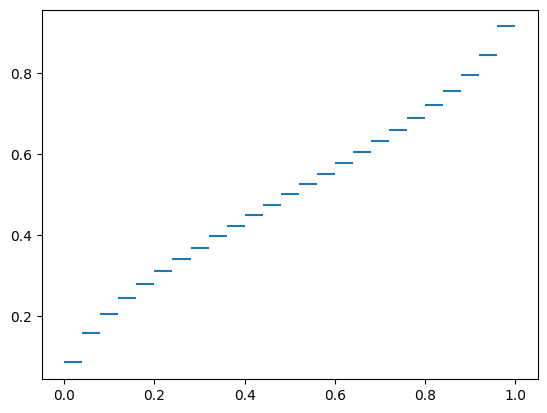

In [262]:
try:
  import firedrake.pyplot as plt
except:
  warning("Matplotlib not imported")

try:
  Line2D = plt.plot(F,num_sample_points=150)
except Exception as e:
  warning("Cannot plot figure. Error msg: '%s'" % e)

Having constructed the CDF $F(y)$ we now turn to constructing its PDF $f(y)$ which must remain positive and integrate to one. While strictly speaking the PDF is the derivative of the CDF, the function above is clearly discontinous and constructing a finite element basis for $V_F$ with continuous first derivatives is perhaps unescessary if we can contend ourselves with $f(y)$ being only weakly differentiable. To this end we choose to recover the PDF via a projection as this requires less regularlity. To do so define the function space $V_f $ of $f(y)$ to be
\begin{equation*}
    f \in V_f \subset H^1(\Omega_Y), \quad \text{where} \quad f:\Omega_Y \to \mathbb{R}^+ \quad \text{s.t.} \; \left\{ \int f^2 dy < \infty, \int |\nabla f|^2 dy < \infty \right\},
\end{equation*}
thus allowing for weak derivatives followed by a set of basis functions $V_f = span\{\varphi_i(y)\}$ such that
\begin{equation*}
    f(y) = \sum_i f_i \varphi_i(y).
\end{equation*}
We then define the projection in each element $e$ as
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = \int_{e} \varphi_e \partial_y F(y) \; dy, \quad \text{where} \quad \forall \varphi_e \in V_{e},
\end{equation*}
which can be integrated by parts in order to put the derivative onto $v$ thus resulting in a boundary flux
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = -\int_{e} F(y) \partial_y \varphi_e \; dy + \int_{\partial e} F \varphi_e \cdot \vec{n}_e \; dS, \quad \text{where} \quad \forall \varphi_e \in V_{e},
\end{equation*}
and $\vec{n}_e$ is the outward pointing unit normal. Since $F$ is discontinuous, as evidenced by the previous figure, we have to choose how it is defined at the element facets. To ensure a stable scheme we choose upwinding, which means that must must specify the choice of $F$ at the edges of the domain as well as the interior facets.

Summing the contribution of all the elements $\sum_e \int_e \cdot \; dy = \int_{\Omega_Y} \cdot \; dy$ we obtain
\begin{align}
    \int_{\Omega_Y} v f(y) \; dy = & - \int_{\Omega_Y}        F(y) \partial_y v \; dy \\
                                   & + \int_{\Gamma_{int}}    F_+ v \cdot \vec{n}_e \; dS \\
                                   & + \int_{\Gamma_{max(y)}} F_- v \cdot \vec{n} \; ds \quad \forall v \in V_{f},
\end{align}
where the terms on the left hand side correspond to the cell integral and the integral at right most boundary where we take the interior solution $F_-$. The left most boundary need not be included as for a CDF $F=0$ by definition while the integral over the set of all interior facets $\Gamma_{int}$ vanishes when we upwind.

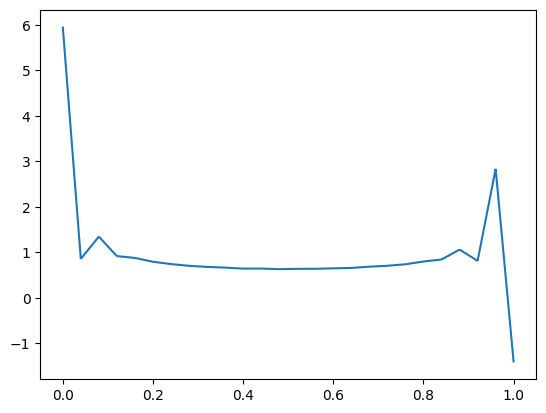

In [263]:
# Define a function space
V_f = FunctionSpace(mesh=m_y,family="CG",degree=1);

u = TrialFunction(V_f)
v = TestFunction(V_f)

n = FacetNormal(m_y)

# create new function y_Fs on function space V
#V_F = FunctionSpace(mesh=m_y,family="DG",degree=0);
#y,  = SpatialCoordinate(m_y)
#F   = interpolate(y,V_F) # Creates a function y in V_F

# Define the variational forms for the previous equation
a =  inner(u,v) * dx
L = -inner(F,v.dx(0)) * dx  +  F*v*ds(2)


f = Function(V_f)
solve(a == L, f)
File("PDF_Rayleigh_Benard.pvd").write(f)

try:
  Line2D = plt.plot(f,num_sample_points=150)
except Exception as e:
  warning("Cannot plot figure. Error msg: '%s'" % e)